# Data : 
A Malware can belong to one of the following class : 
 * Adialer.C
 * Agent.FYI
 * Allaple.A
 * Allaple.L
 * Alueron.gen!J
 * Autorun.K
 * C2LOP.P
 * C2LOP.gen!g
 * Dialplatform.B
 * Dontovo.A
 * Fakerean
 * Instantaccess
 * Lolyda.AA1
 * Lolyda.AA2
 * Lolyda.AA3
 * Lolyda.AT
 * Malex.gen!J
 * Obfuscator.AD
 * Rbot!gen
 * Skintrim.N
 * Swizzor.gen!E
 * Swizzor.gen!I
 * VB.AT
 * Wintrim.BX
 * Yuner.A

# Preprocessing - Converting to images

Raw malwares will be stored in the following folder:

In [1]:
root = ".\dataRaw"

files :  ['0A32eTdBKayjCWhZqDOQ.bytes', '0A32eTdBKayjCWhZqDOQ.bytes.png', '0ACDbR5M3ZhBJajygTuf.bytes', '0ACDbR5M3ZhBJajygTuf.bytes.png']
Processing 0A32eTdBKayjCWhZqDOQ.bytes
Processing 0ACDbR5M3ZhBJajygTuf.bytes


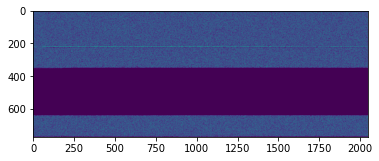

In [2]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

def convertAndSave(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: 
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    im.save(root+'\\'+name+'.png', "PNG")
    return im

files=os.listdir(root)
print('files : ',files)
for counter, name in enumerate(files):
        if '.bytes' != name[-6:]:
            continue
        f=open(root+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(convertAndSave(np.array(array),name))
        del array
        f.close()

# Preprocessing - Generate the dataset

In [3]:
path_root = ".\data\malimg_paper_dataset_imgs\\"

In [4]:
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [5]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [6]:
imgs, labels = next(batches)

In [7]:
imgs.shape

(9339, 64, 64, 3)

In [8]:
labels.shape

(9339, 25)

In [9]:
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

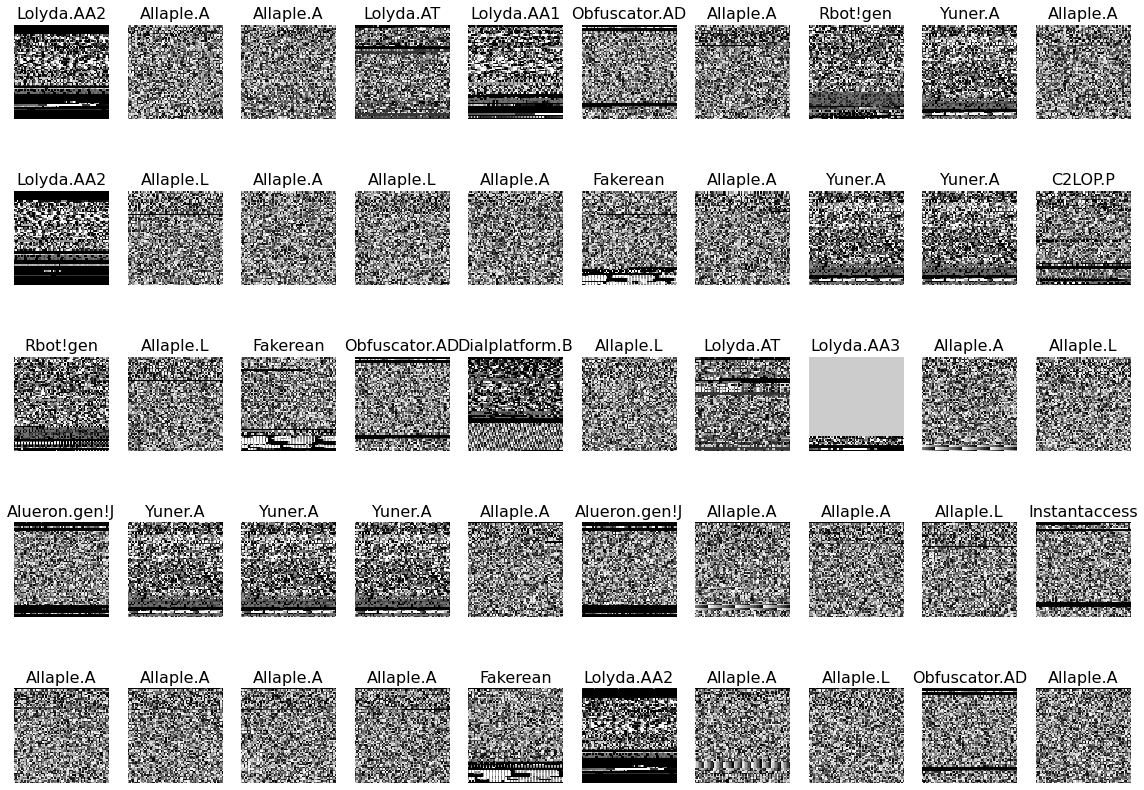

In [10]:
plots(imgs, titles = labels)

# Analyse 

In [11]:
classes = batches.class_indices.keys()

In [12]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

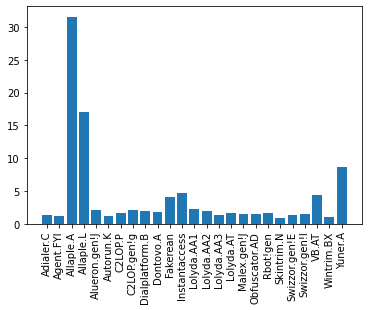

In [13]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

# Train and test

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [15]:
X_train.shape

(6537, 64, 64, 3)

In [16]:
X_test.shape

(2802, 64, 64, 3)

In [17]:
y_train.shape

(6537, 25)

In [18]:
y_test.shape

(2802, 25)

## Convolutional Neural Network Model

We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, Relu activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 3

In [19]:
import keras
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, Input, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [20]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [21]:
num_classes = 25

In [22]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [23]:
Malware_model = malware_model()

In [24]:
Malware_model.build(input_shape=(None,64,64,3))
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 62, 62, 30)        840       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 31, 31, 30)        0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 29, 29, 15)        4065      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 14, 14, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2940)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [25]:
y_train.shape

(6537, 25)

In [26]:
y_train_new = np.argmax(y_train, axis=1)

In [27]:
y_train_new

array([ 5, 11, 24, ...,  2,  8, 23], dtype=int64)

In [28]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train_new),
                                                 y=y_train_new)

In [29]:
class_weights = {i : class_weights[i] for i in range(25)}

In [30]:
class_weights

{0: 2.752421052631579,
 1: 3.2685,
 2: 0.12811366976972072,
 3: 0.23814207650273225,
 4: 1.8158333333333334,
 5: 3.581917808219178,
 6: 2.588910891089109,
 7: 1.7787755102040816,
 8: 2.1432786885245902,
 9: 2.2737391304347825,
 10: 0.9543065693430657,
 11: 0.8804040404040404,
 12: 1.7316556291390728,
 13: 2.0269767441860465,
 14: 3.352307692307692,
 15: 2.3988990825688075,
 16: 2.6956701030927834,
 17: 2.8421739130434784,
 18: 2.3988990825688075,
 19: 4.842222222222222,
 20: 2.538640776699029,
 21: 2.9379775280898874,
 22: 0.862970297029703,
 23: 3.789565217391304,
 24: 0.46116402116402117}

In [31]:
loss_fn2 = tf.keras.losses.CategoricalCrossentropy()
Malware_model.compile(optimizer='adam', loss=loss_fn2, metrics=['accuracy'])
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25,  class_weight=class_weights)

Epoch 1/25
205/205 [==============================] - 13s 61ms/step - loss: 1.8421 - accuracy: 0.4667 - val_loss: 0.9636 - val_accuracy: 0.6895
Epoch 2/25
205/205 [==============================] - 13s 64ms/step - loss: 0.8665 - accuracy: 0.7216 - val_loss: 0.3949 - val_accuracy: 0.9029
Epoch 3/25
205/205 [==============================] - 13s 63ms/step - loss: 0.4873 - accuracy: 0.8574 - val_loss: 0.2327 - val_accuracy: 0.9343
Epoch 4/25
205/205 [==============================] - 14s 67ms/step - loss: 0.3409 - accuracy: 0.8998 - val_loss: 0.1703 - val_accuracy: 0.9493
Epoch 5/25
205/205 [==============================] - 15s 75ms/step - loss: 0.2743 - accuracy: 0.9175 - val_loss: 0.1682 - val_accuracy: 0.9511
Epoch 6/25
205/205 [==============================] - 13s 66ms/step - loss: 0.2174 - accuracy: 0.9364 - val_loss: 0.1631 - val_accuracy: 0.9547
Epoch 7/25
205/205 [==============================] - 13s 65ms/step - loss: 0.2106 - accuracy: 0.9336 - val_loss: 0.1466 - val_accuracy:

In [32]:
scores = Malware_model.evaluate(X_test, y_test)

88/88 [==============================] - 1s 14ms/step - loss: 0.1416 - accuracy: 0.9615


In [33]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9614561200141907


# Confusion Matrix

In [34]:
import numpy as np
import pandas as pd

In [35]:
y_pred = Malware_model.predict_classes(X_test, verbose=0)

C:\Users\90507\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
y_pred

array([ 2,  2, 24, ...,  4,  2, 13], dtype=int64)

In [37]:
y_test2 = np.argmax(y_test, axis=1)

In [38]:
y_test2

array([ 2,  2, 24, ...,  4,  2, 13], dtype=int64)

In [39]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [40]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

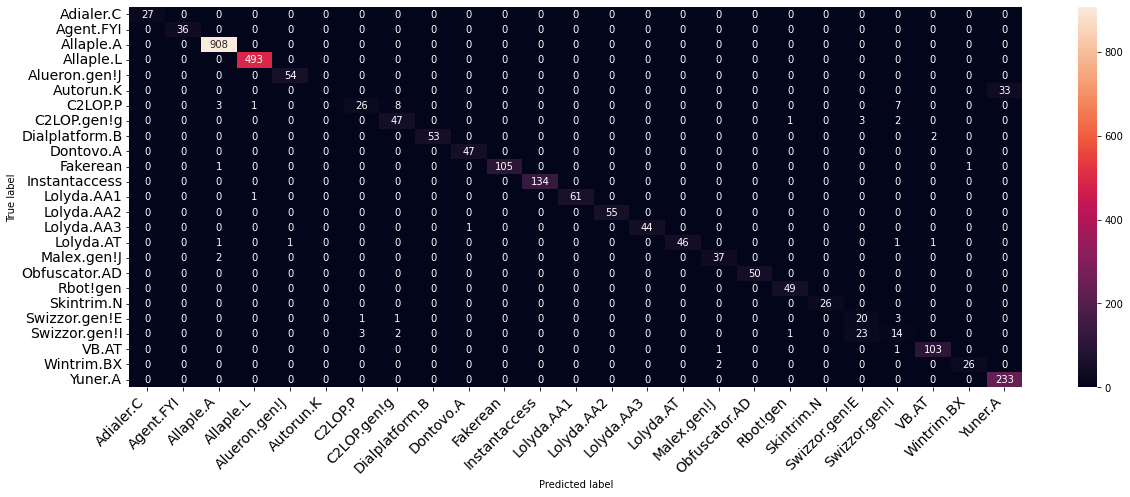

In [41]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

In [42]:
import numpy as np

ewc_lambda = 0.5  
fisher_matrices = []  
importance_matrices = []  

for layer in Malware_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()[0]
        input_shape = layer.input_shape[1:]
        output_shape = layer.output_shape[1:]
        num_inputs = np.prod(input_shape)
        num_outputs = np.prod(output_shape)
        inputs = np.random.rand(100, *input_shape)
        outputs = Malware_model.predict(inputs)
        fisher_matrix = np.zeros((num_outputs, num_inputs, num_inputs))
        for i in range(100):
            output = outputs[i].reshape(num_outputs, 1)
            input_vec = inputs[i].reshape(num_inputs, 1)
            fisher_matrix += np.matmul(output, input_vec.T)
        fisher_matrix /= 100
        fisher_matrices.append(fisher_matrix)

prev_task_acc = 0.9  
new_task_acc = 0.8  
for fisher_matrix in fisher_matrices:
    importance_matrix = ewc_lambda * (fisher_matrix / prev_task_acc)
    importance_matrix += (1 - ewc_lambda) * (fisher_matrix / new_task_acc)
    importance_matrices.append(importance_matrix)

regularization_terms = []
for i, layer in enumerate(Malware_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()[0]
        regularization_term = ewc_lambda * np.matmul(importance_matrices[i], (weights**2).flatten())
        regularization_terms.append(regularization_term)

def ewc_loss(y_true, y_pred):
    cross_entropy_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    ewc_loss = cross_entropy_loss
    for regularization_term in regularization_terms:
        ewc_loss += regularization_term
    return ewc_loss

Malware_model.compile(optimizer='adam',
              loss=ewc_loss,
              metrics=['accuracy'])

In [43]:
batches_f = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)
imgs_f, labels_f = next(batches_f)

Found 9339 images belonging to 25 classes.


In [44]:
classes_f = batches_f.class_indices.keys()

In [45]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(imgs_f/255.,labels_f, test_size=0.3)
y_train_new_f = np.argmax(y_train_f, axis=1)

In [46]:
loss_fn_f = tf.keras.losses.CategoricalCrossentropy()
Malware_model.fit(X_train_f, y_train_f, epochs=25, validation_data=(X_test_f, y_test_f))

Epoch 1/25
205/205 [==============================] - 13s 60ms/step - loss: 0.1287 - accuracy: 0.9615 - val_loss: 0.0801 - val_accuracy: 0.9793
Epoch 2/25
205/205 [==============================] - 12s 60ms/step - loss: 0.1113 - accuracy: 0.9647 - val_loss: 0.0820 - val_accuracy: 0.9786
Epoch 3/25
205/205 [==============================] - 13s 61ms/step - loss: 0.1007 - accuracy: 0.9705 - val_loss: 0.0748 - val_accuracy: 0.9807
Epoch 4/25
205/205 [==============================] - 12s 61ms/step - loss: 0.1038 - accuracy: 0.9673 - val_loss: 0.0776 - val_accuracy: 0.9782
Epoch 5/25
205/205 [==============================] - 12s 60ms/step - loss: 0.0981 - accuracy: 0.9688 - val_loss: 0.0858 - val_accuracy: 0.9782
Epoch 6/25
205/205 [==============================] - 13s 62ms/step - loss: 0.1003 - accuracy: 0.9673 - val_loss: 0.0821 - val_accuracy: 0.9754
Epoch 7/25
205/205 [==============================] - 14s 68ms/step - loss: 0.0910 - accuracy: 0.9702 - val_loss: 0.0880 - val_accuracy:

In [47]:
scores2 = Malware_model.evaluate(X_test_f, y_test_f)

88/88 [==============================] - 1s 14ms/step - loss: 0.0989 - accuracy: 0.9729


In [64]:
original_task_change = Malware_model.evaluate(X_test, y_test)
new_task_change = Malware_model.evaluate(X_test_f, y_test_f)

88/88 [==============================] - 1s 12ms/step - loss: 0.0989 - accuracy: 0.9729


In [65]:
original_task_change = scores[0] - original_task_change[0], scores[1] - original_task_change[1]
new_task_change = scores2[0] - new_task_change[0], scores2[1] - new_task_change[1]

In [66]:
print("First = ",scores," *** Second = ",scores2)
print("Original Task Change = ",original_task_change,"\nNew Task Change = ",new_task_change)

First =  [0.14162591099739075, 0.9614561200141907]  *** Second =  [0.09892039000988007, 0.9728764891624451]
Original Task Change =  (0.06661544740200043, -0.018558144569396973) 
New Task Change =  (0.0, 0.0)


In [67]:
if(original_task_change[0]>=0 and original_task_change[1]<=0):
    print("Previous Task accuracy and loss didn't effected negatively")
if(new_task_change[0]>=0 and new_task_change[1]<=0):
    print("New Task accuracy and loss didn't effected negatively")

Previous Task accuracy and loss didn't effected negatively
New Task accuracy and loss didn't effected negatively
